# Optical Flow Trajectory Prediction

## Imports and Utility

In [1]:
import os

import numpy as np
import numpy.linalg as npl
import pandas as pd
import scipy
import cv2 as cv
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

PROJECT_DEBUG = True

output_notebook()

Loading BokehJS ...

In [4]:
def load_image_gray(filepath: str) -> np.ndarray:
    im = cv.imread(filepath)
    img = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
    mi = np.min(img)
    ma = np.max(img)
    return img / float(ma - mi)

def parse_meta(folder: str) -> Tuple[int, int, int, int]:
    supported_types = ['png', 'txt']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    if 'meta.txt' not in supported_files:
        raise FileNotFoundError(f'meta.txt not found in {folder}')
    else:
        with open(os.path.join(folder, 'meta.txt'), 'r') as f:
            lines = f.readlines()
            if len(lines) < 4:
                raise Exception(f'Not enough lines in meta.txt')
            frame_width, frame_height, num_frames, frame_rate = (int(line) for line in lines[:4])

    return (frame_width, frame_height, num_frames, frame_rate)

def load_image_sequence(folder: str) -> np.ndarray:
    supported_types = ['png', 'txt']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]
    unsupported_files = [f for f in all_files if f not in supported_files]

    if PROJECT_DEBUG:
        if unsupported_files != []:
            print(f'Warning! Following files from {folder} are unsupported, ignoring: {", ".join(unsupported_files)}')

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

    if num_frames == 0:
        raise Exception(f'Folder must have at least one frame')
    if frame_width == 0 or frame_height == 0:
        raise Exception(f'Dimensions must result in non-zero number of pixels')

    image_files = [f for f in all_files if f.endswith('png')]

    if len(image_files) < num_frames:
        raise FileNotFoundError(f'Not enough files for number of frames specified in meta.txt ({len(image_files)} < {num_frames})')

    video = np.zeros((num_frames, frame_height, frame_width))

    for f_no, img_file in enumerate(image_files):
        video[f_no, :, :] = load_image_gray(os.path.join(folder, img_file))

    return video

## Derivatives

In [66]:
convolve = lambda img, flt: scipy.ndimage.convolve(img, flt, mode='nearest')

def horiz_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]],
        [[-2, 0, 2],
         [-4, 0, 4],
         [-2, 0, 2]],
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1],]
    ])

    return convolve(video, filt)

def vert_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
        [[-2, -4, -2],
         [0, 0, 0],
         [2, 4, 2]],
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

def time_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [-2, -4, -2],
         [-1, -2, -1]],
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
        [[1, 2, 1],
         [2, 4, 2],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

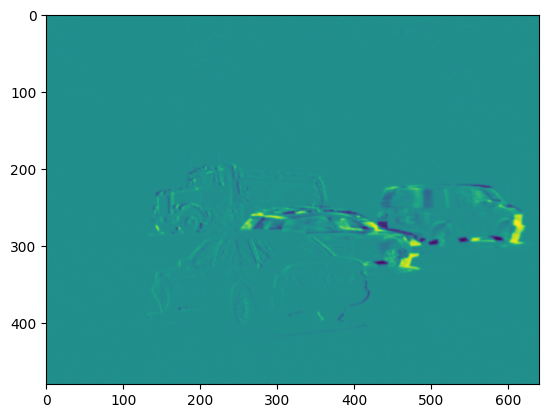

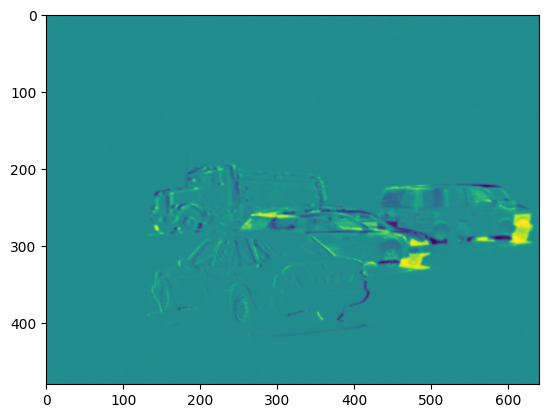

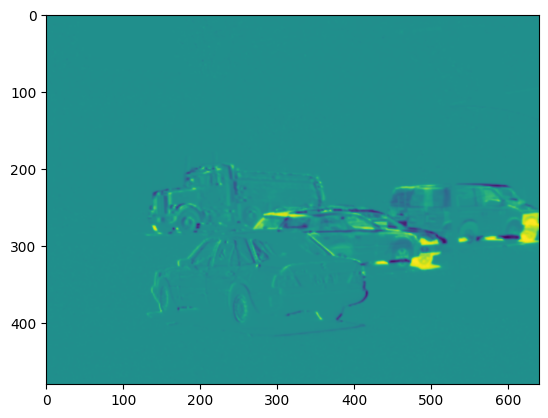

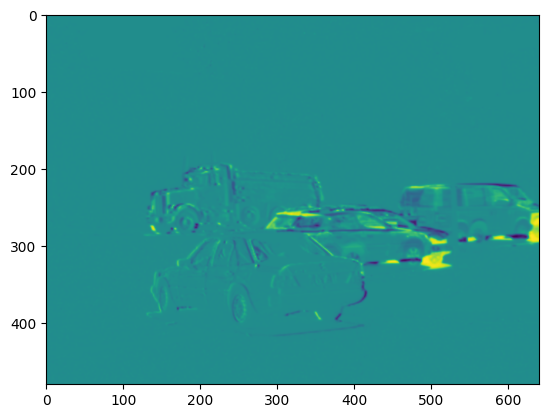

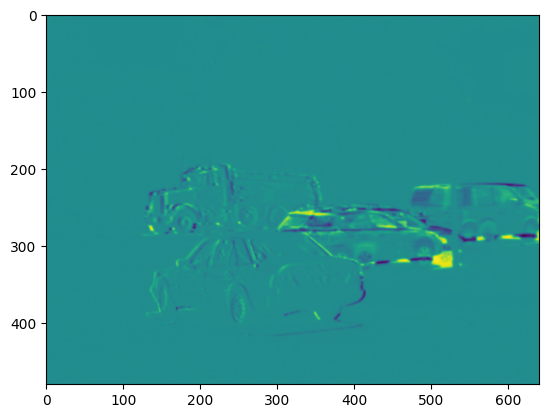

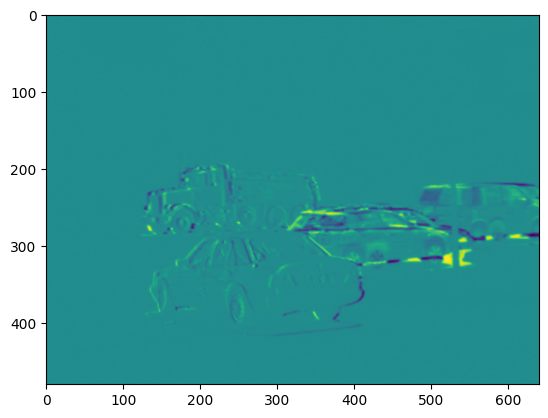

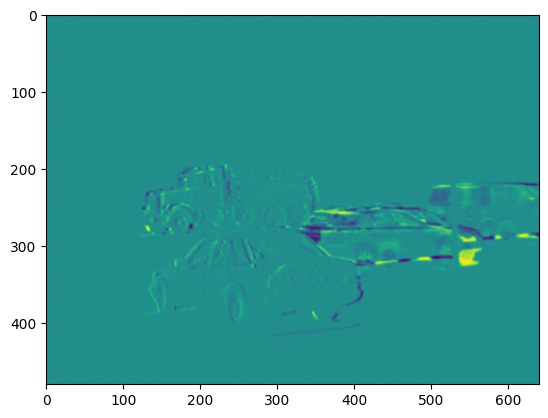

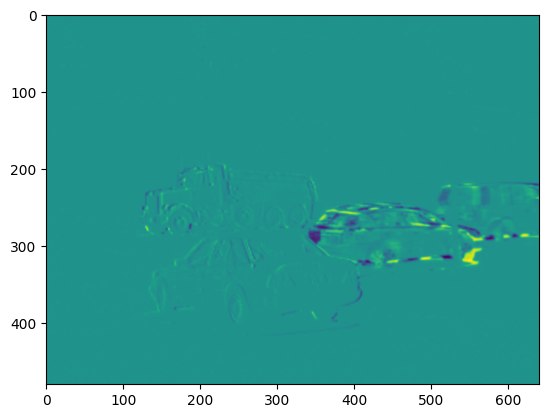

In [93]:
folder = './other_tests/dumptruck/'
# folder = './blender_tests/throw1/mist/'

video = load_image_sequence(folder)
frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

I_x = horiz_deriv(video)
I_y = vert_deriv(video)
I_t = time_deriv(video)

for deriv in I_t:
    plt.figure()
    plt.imshow(deriv)

## Feature Detection

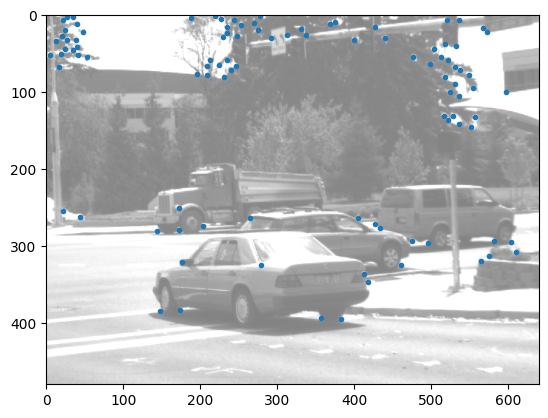

In [101]:
first_frame = video[0]
mask1 = np.zeros_like(first_frame)
mask1[:, 650:850] = 1
mask2 = np.zeros_like(first_frame)
mask2[100:200, :] = 1

mask = np.logical_and(mask1, mask2).astype(np.uint8)

track_points = cv.goodFeaturesToTrack(
    first_frame.astype('f4'),
    maxCorners=100,
    qualityLevel=0.1,
    minDistance=7,
    blockSize=7,
    mask=None)

plt.figure()
plt.imshow(first_frame, cmap='gray', vmin=-1, vmax=1)
plt.scatter(track_points[:, 0, 0], track_points[:, 0, 1], marker='.')


## Tracking

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


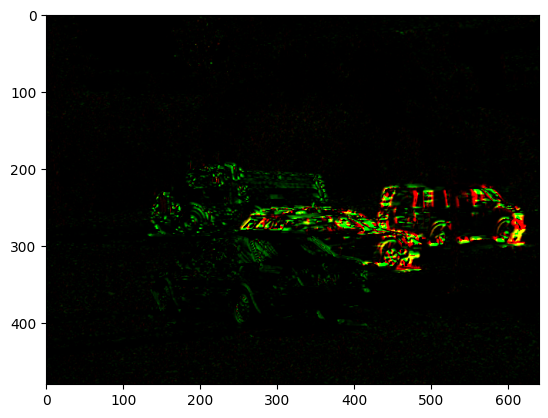

In [118]:
WINDOW_SIZE = 5

def get_window_coordinates(center: Tuple[int, int], win_size: int, lower_clamp=True) -> List[Tuple[int, int]]:
    xs = [x for x in range(center[0] - win_size // 2, center[0] + win_size // 2 + 1) if (not lower_clamp) or (x >= 0)]
    ys = [y for y in range(center[1] - win_size // 2, center[1] + win_size // 2 + 1) if (not lower_clamp) or (y >= 0)]

    coords = [(x, y) for x in xs for y in ys]
    return coords

frame1 = video[0]
frame2 = video[1]

u_field = np.zeros_like(frame1)
v_field = np.zeros_like(frame1)
zeroes = np.zeros_like(frame1)

l = 0.01

# while True:
for i in range(100):
    calculation = (I_x[0] * u_field + I_y[0] * v_field + I_t[0]) / ((1 / l) + I_x[0] ** 2 + I_y[0] ** 2)
    u_field -= calculation * I_x[0]
    v_field -= calculation * I_y[0]

x, y = np.meshgrid(np.arange(frame1.shape[0]), np.arange(frame1.shape[1]))

plt.figure()
plt.imshow(np.stack((u_field, v_field, zeroes), axis=2), vmin=-1, vmax=1)
# plt.quiver(x[::10], y[::10], u_field[::10, ::10], v_field[::10, ::10], color='r')
# plt.figure()
# plt.imshow(v_field, vmin=-1, vmax=1)
